### Problem Statement

*Predicting housing prices is of interest to potential buyers, sellers, and organizations alike. Multiple online platforms offer, for example, a free “price estimate” based on underlying machine learning models. For this assignment, we are going to build the best machine learning model we can for Ames, Iowa. The data set consists of 79 features that describe the quality and quantity of the properties to base our predictions on.*

# Task 0: Data Preperation

*Note: No code has to be written for the 5 cells below - you may just execute them sequentially. After this, you may move on to **Task 1** on understanding the data.*

In [37]:
!pip install missingno

In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import HTML, display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from scipy.stats import pearsonr

import missingno as msno
%matplotlib inline

In [40]:
# All missing data removed/cleaned
housing_df = pd.read_csv("ames_data_no_missing.csv", index_col=0)

In [41]:
#Check the number of dummies to be created
count = [housing_df[col].nunique() for col in housing_df.columns if housing_df[col].dtype==object]
sum(count)

269

In [42]:
# ensure Python reads the categorical variables as categorical
for column in housing_df.columns:
    if housing_df[column].dtype == 'object':
        housing_df[column] = pd.Categorical(housing_df[column])

In [43]:
#define our RMSE function
def rmse(y_train, y_pred):
    return np.sqrt(mean_squared_error(y_train, y_pred))

In [44]:
def display_dataframe_as_html(df):
    """
    Convert DataFrame to HTML and display it as scrollable HTML content in Jupyter Notebook.
    
    Parameters:
    - df (pandas.DataFrame): The DataFrame to be displayed.
    """
    html_content = df.to_html()
    display(HTML(html_content))

In [45]:
def describe_categorical_data(df):
    """
    Describe categorical data in a DataFrame.
    
    Parameters:
    - df (pandas.DataFrame): The DataFrame containing categorical data.
    
    Returns:
    - pandas.DataFrame: A summary of descriptive statistics for categorical columns.
    """
    # Select only categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category'])
    
    # Get summary statistics for each categorical column
    summary_stats = []
    for col in categorical_cols.columns:
        stats = {
            'Column': col,
            'Unique Values': df[col].nunique(),
            'Top Value': df[col].mode().iloc[0],
            'Frequency': df[col].value_counts().iloc[0],
            'Frequency (%)': df[col].value_counts(normalize=True).iloc[0] * 100
        }
        summary_stats.append(stats)
    
    # Create a DataFrame from the summary statistics
    summary_df = pd.DataFrame(summary_stats)
    summary_df = summary_df.set_index('Column')
    
    return summary_df

# Task 1: Understand the Data
*Take some time to familiarize yourself with the data. It contains information about housing prices in Ames. What are the key variables?*

*You may perform any additional EDA if necessary.*

### 1.0.1: EDA

In [59]:
housing_df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Lot Config,Land Slope,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
PID,,,,,,,,,,,,,,,,,,,,,
526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,Corner,Gtl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,Corner,Gtl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,Corner,Gtl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,Inside,Gtl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [46]:
display_dataframe_as_html(housing_df.dtypes.to_frame())

,0
MS SubClass,int64
MS Zoning,category
Lot Frontage,float64
Lot Area,int64
Street,category
Alley,category
Lot Shape,category
Land Contour,category
Lot Config,category
Land Slope,category


In [47]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2930 entries, 526301100 to 924151050
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS SubClass      2930 non-null   int64   
 1   MS Zoning        2930 non-null   category
 2   Lot Frontage     2930 non-null   float64 
 3   Lot Area         2930 non-null   int64   
 4   Street           2930 non-null   category
 5   Alley            198 non-null    category
 6   Lot Shape        2930 non-null   category
 7   Land Contour     2930 non-null   category
 8   Lot Config       2930 non-null   category
 9   Land Slope       2930 non-null   category
 10  Neighborhood     2930 non-null   category
 11  Condition 1      2930 non-null   category
 12  Condition 2      2930 non-null   category
 13  Bldg Type        2930 non-null   category
 14  House Style      2930 non-null   category
 15  Overall Qual     2930 non-null   int64   
 16  Overall Cond     2930 non-null   i

In [48]:
display_dataframe_as_html(housing_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
MS SubClass,2930.0,57.387372,42.638025,20.0,20.00,50.000000,70.00,190.0
Lot Frontage,2930.0,69.224537,21.327312,21.0,60.00,69.146502,78.00,313.0
Lot Area,2930.0,10147.921843,7880.017759,1300.0,7440.25,9436.500000,11555.25,215245.0
Overall Qual,2930.0,6.094881,1.411026,1.0,5.00,6.000000,7.00,10.0
Overall Cond,2930.0,5.563140,1.111537,1.0,5.00,5.000000,6.00,9.0
Year Built,2930.0,1971.356314,30.245361,1872.0,1954.00,1973.000000,2001.00,2010.0
Year Remod/Add,2930.0,1984.266553,20.860286,1950.0,1965.00,1993.000000,2004.00,2010.0
Mas Vnr Area,2930.0,101.096928,178.634545,0.0,0.00,0.000000,162.75,1600.0
BsmtFin SF 1,2930.0,442.478498,455.586452,0.0,0.00,370.000000,734.00,5644.0
BsmtFin SF 2,2930.0,49.705461,169.142089,0.0,0.00,0.000000,0.00,1526.0


In [49]:
categorical_summary = describe_categorical_data(housing_df)
display_dataframe_as_html(categorical_summary)

,Unique Values,Top Value,Frequency,Frequency (%)
Column,,,,
MS Zoning,7,RL,2273,77.576792
Street,2,Pave,2918,99.590444
Alley,2,Grvl,120,60.606061
Lot Shape,4,Reg,1859,63.447099
Land Contour,4,Lvl,2633,89.863481
Lot Config,5,Inside,2140,73.037543
Land Slope,3,Gtl,2789,95.187713
Neighborhood,28,NAmes,443,15.119454
Condition 1,9,Norm,2522,86.075085


In [50]:
numeric_features = housing_df.select_dtypes(include=[np.number])

numeric_features.columns

Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice'],
      dtype='object')

In [53]:
categorical_features = housing_df.select_dtypes(include=['category'])

categorical_features.columns

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'Sale Condition'],
      dtype='object')

<Axes: >

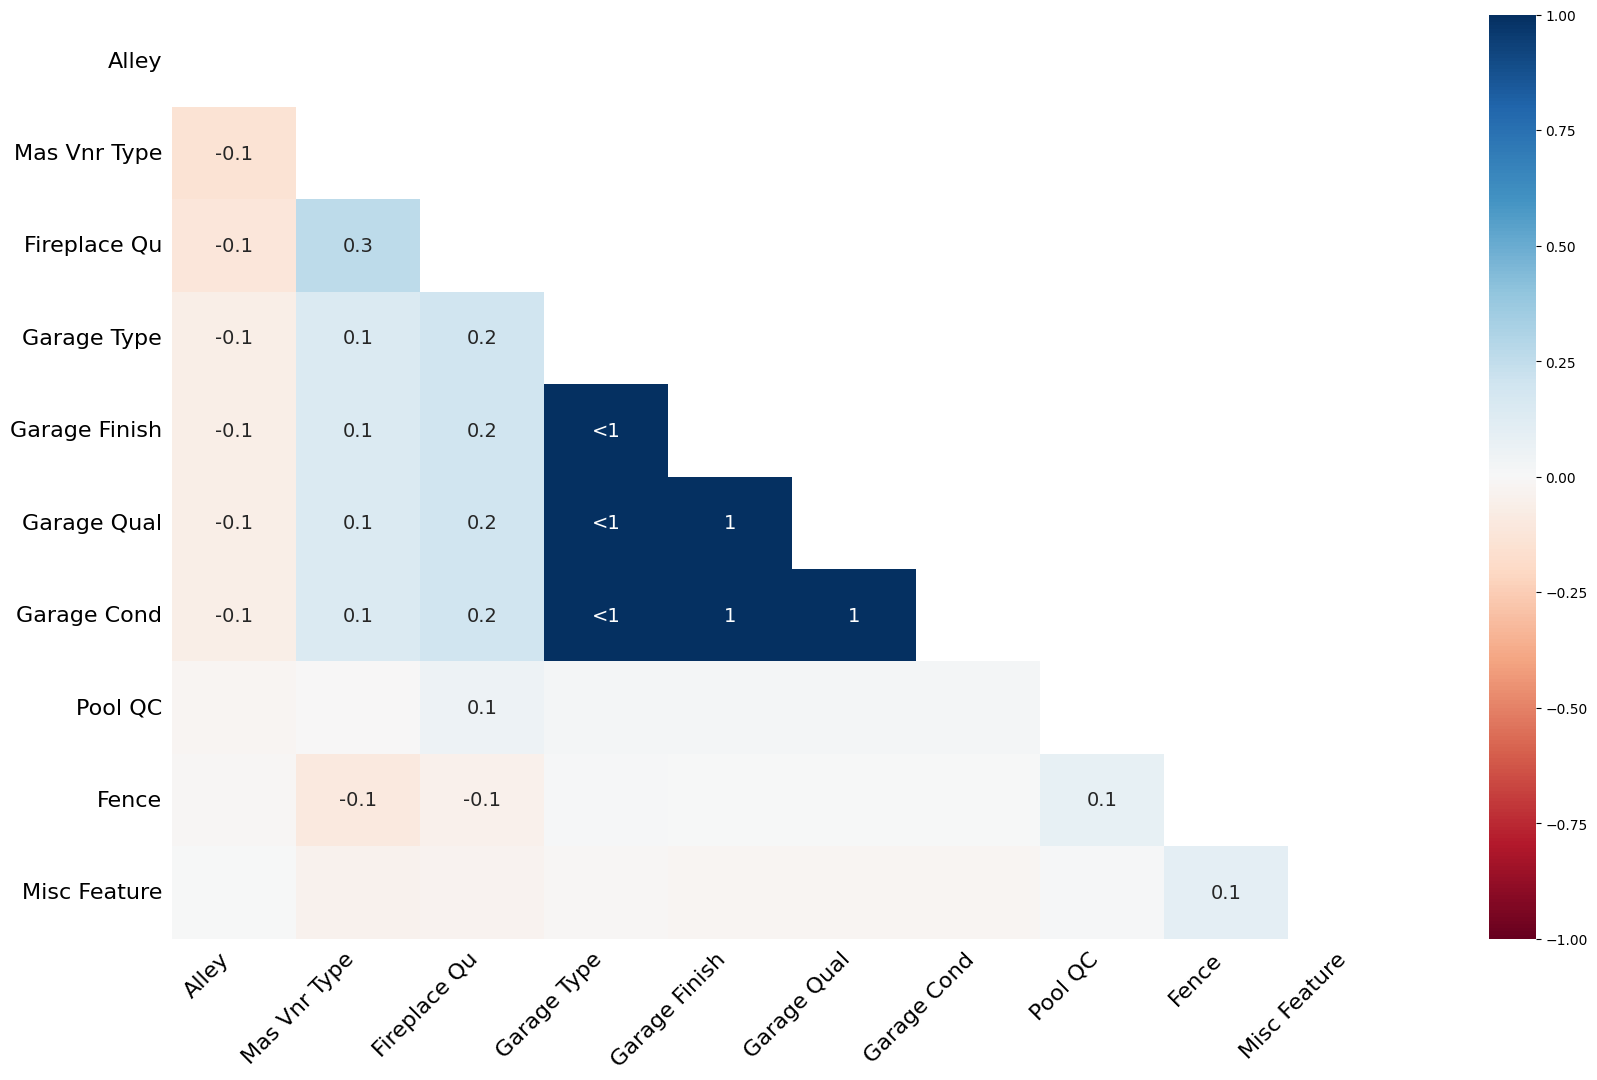

In [57]:
msno.heatmap(categorical_features)

<Axes: >

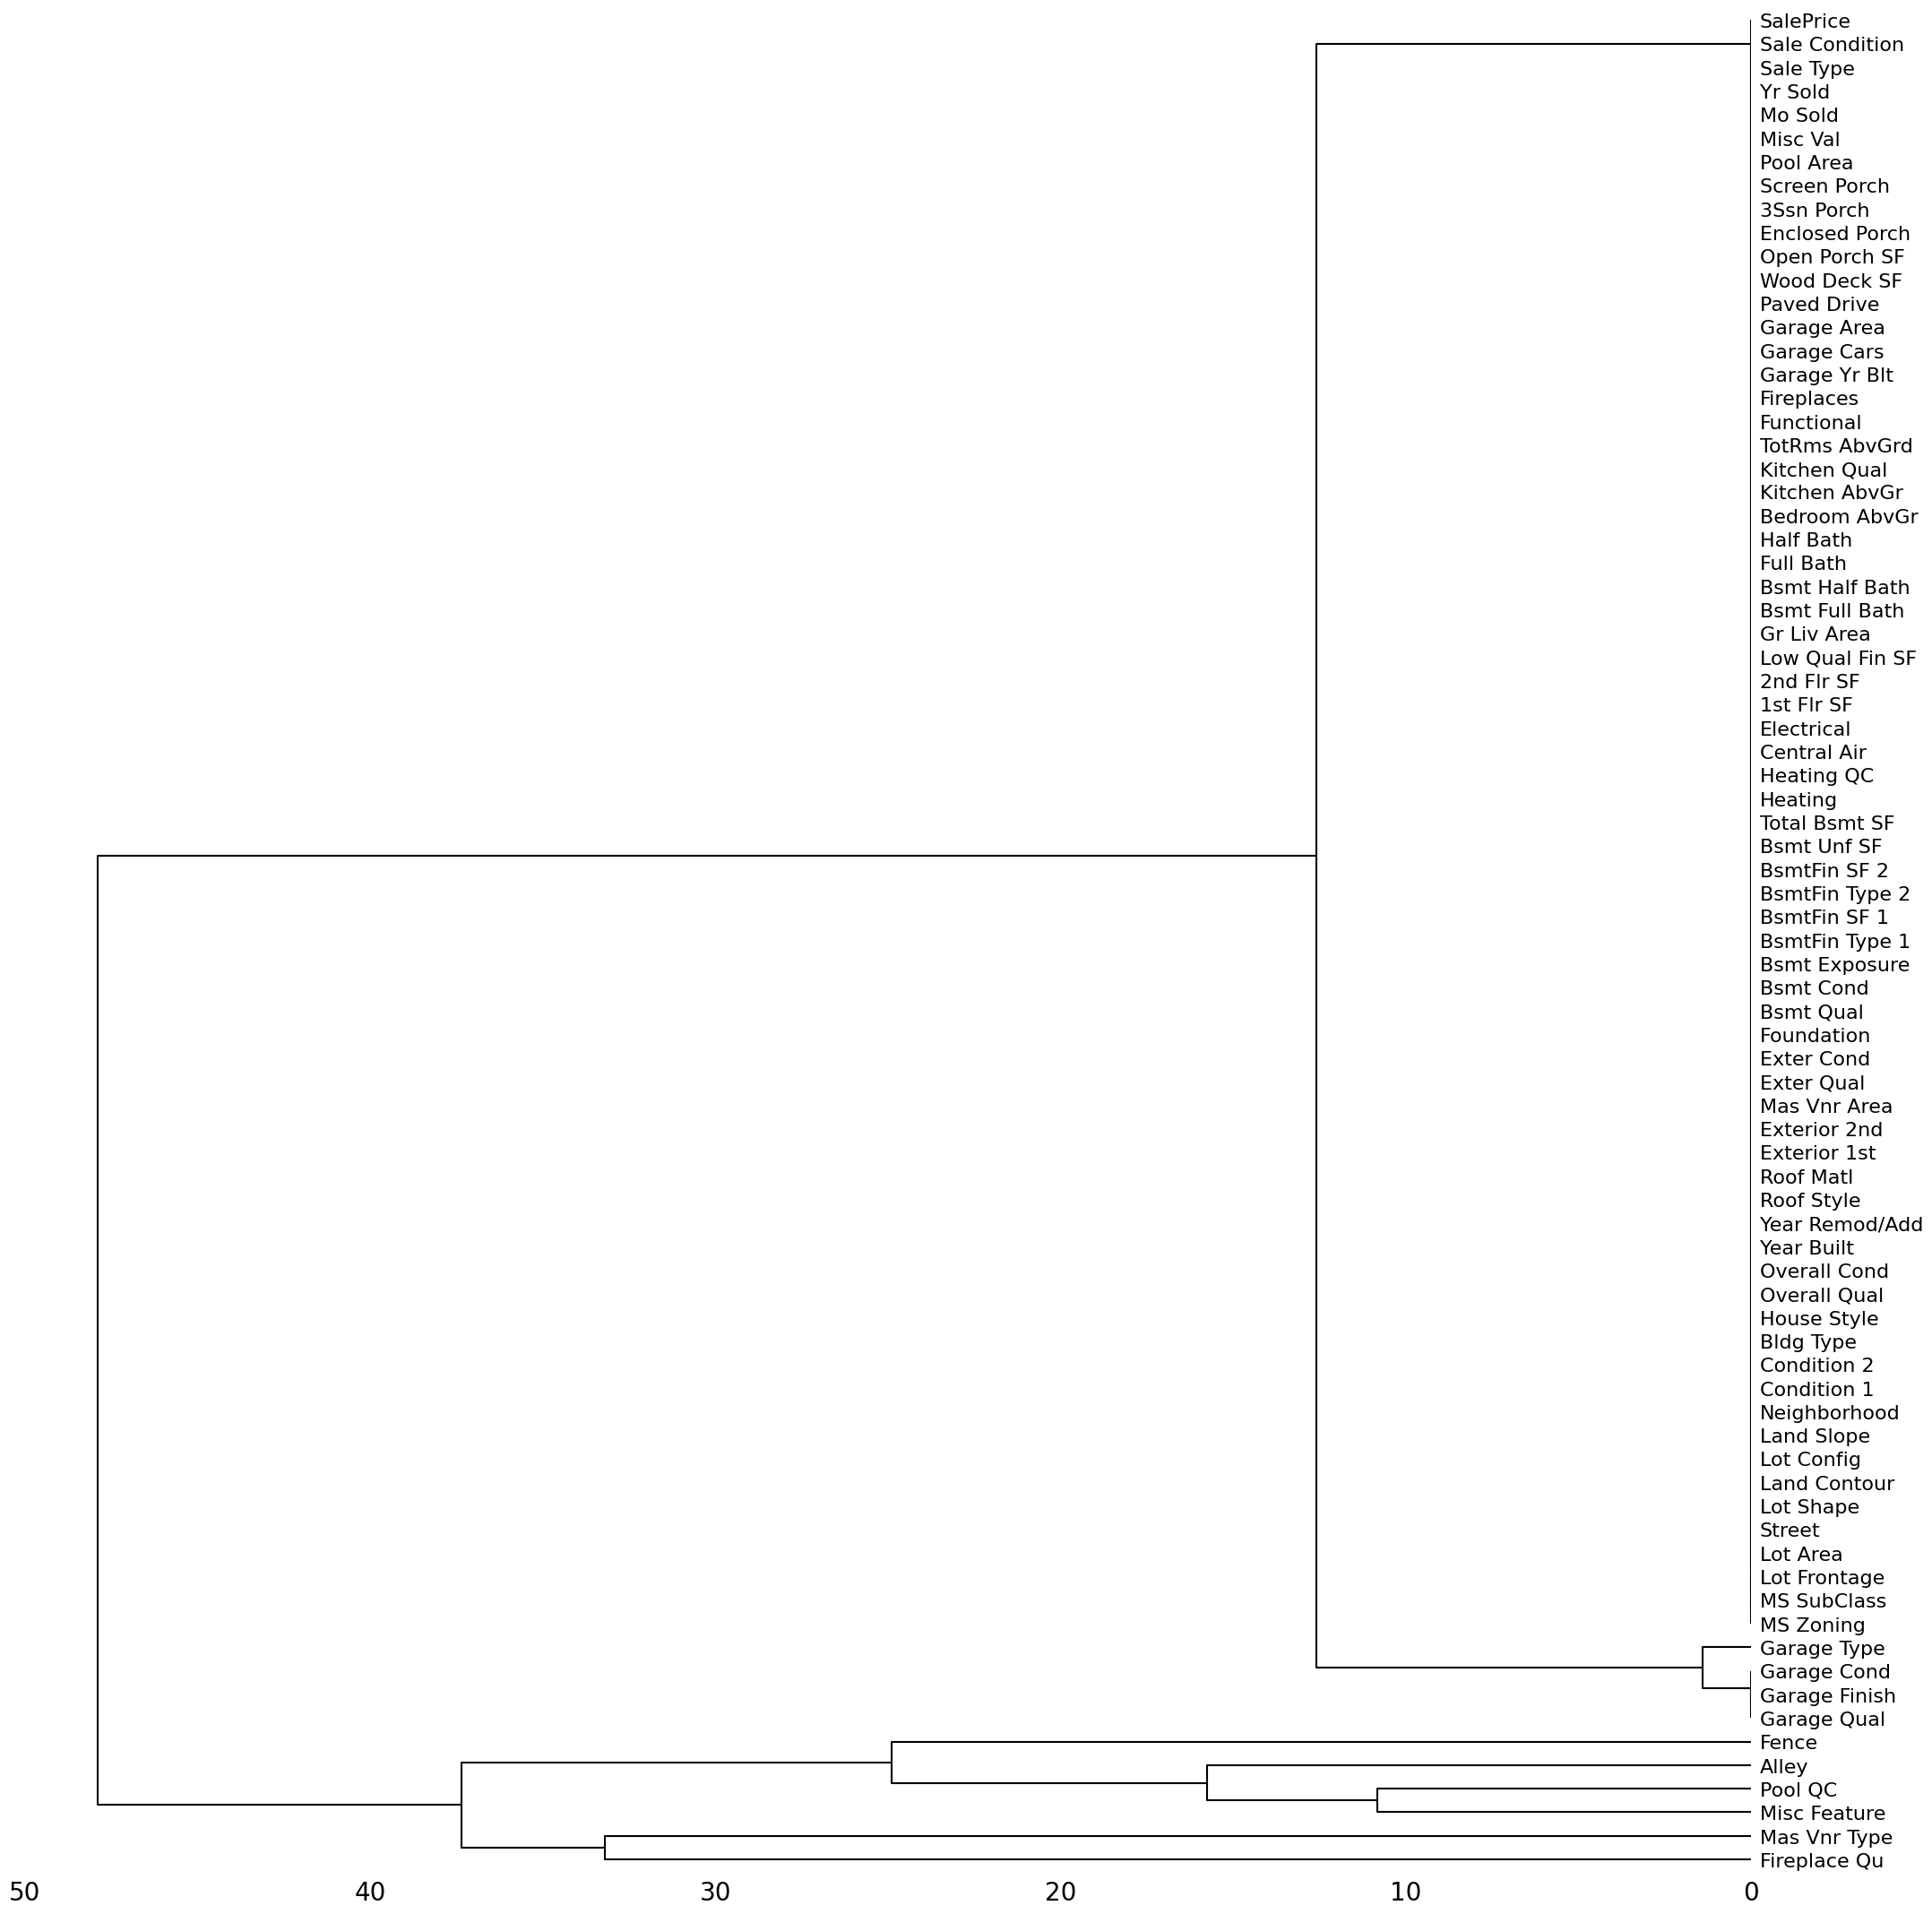

In [58]:
msno.dendrogram(housing_df)

### 1.1
*What is the distribution of housing prices?*

In [ ]:
# The original distribution

##### CODE HERE #####

### 1.2
*What is the variable that has the highest correlation with Housing prices? What are the key drivers behind larger house prices?*

In [ ]:
#Find the correlations of all variables with SalePrice

##### CODE HERE #####

### 1.3
*Create one additional visualization, that gives some insights into the data.*

In [ ]:
# Create a visualization to highlight any insight - Can be a scatter plot, line plot, box plot, histogram or any other visualization that you might know!

##### CODE HERE #####

# Task 2: Build machine learning models

*Use your knowledge of prediction models to create at least three models that predict housing prices.*

### 2.1 
1. *Create dummies for all the categorical columns*.

2. *Partition your data into training and validation (70-30 split, setting the random state to 1).*
3. *Scale the train and the test set using StandardScaler()*

In [ ]:
# Initialize X and y
X = housing_df.drop(columns=['SalePrice']) # All but the outcome column
y = housing_df['SalePrice']

In [ ]:
# Use dummy variables for categorical variables

##### CODE HERE #####

In [ ]:
# Train - Test split (70-30 split, setting the random state to 1)

##### CODE HERE #####

In [ ]:
# Scale the train and test set features separately
scaler = StandardScaler()
numeric_cols = [col for col in X.columns if X[col].dtypes != 'category']

##### CODE HERE #####

### 2.2
*Build a linear regression model, a regression tree and a kNN model. Carefully apply regularization for the linear regression model. Carefully select which variables to use for the kNN model.*

In [ ]:
# Linear model - USE LassoCV to get the best LASSO model

##### CODE HERE #####

In [ ]:
# Tree Model - Use max depth to control the complexity of the tree. Run a Grid search for multiple values of max depth.

##### CODE HERE #####

In [ ]:
# KNN Model

# Select the top 20 most correlated features and store it in a list called 'top_20_features' (using similar correlation table from Task 1)

top_20_features = ##### CODE HERE #####


#For building the model, you must use X_train[top_20_features]

##### CODE HERE #####



# Find the value of k for which RMSE is minimum, using GridSearchCV

##### CODE HERE #####

### 2.3
*Summarize the predictive performance in terms of RMSE.* 
1. *Calculate the RMSE values for train and validation for all the models*
2. *Display them in a tabulated format*

Hint: You may use the code that you've learnt in the 'Model selection' module

In [ ]:
#linear regression

##### CODE HERE #####



#max depth pruned tree

##### CODE HERE #####



#knn

##### CODE HERE #####



#Display the RMSEs

##### CODE HERE #####

### 2.4
*Study the largest errors that you made (largest overpredictions, largest underpredictions). What may be some of the reasons why the model is over/under predicting? Do these insights possibly help you improve the models?*

In [ ]:
# Visualize the errors - plot a scatterplot of the residuals vs the true SalePrice

##### CODE HERE #####

# Task 3

### 3.1
*Are you able to improve your linear regression model by taking the log of the dependent variable? (remember to translate your predicted outcome back to the original units before calculating the RMSE)*

*Create a visualization, that highlights the distribution of prices when after taking log of the dependent variable*

Hint - You may use [numpy.log()](https://numpy.org/doc/stable/reference/generated/numpy.log.html) to get the log of the dependent variable

In [ ]:
# distribution of the transformed SalePrice

##### CODE HERE #####

In [ ]:
# Linear model - Using the log of the SalePrice as the dependent variable, run the LassoCV to obtain the best LASSO model
# Note that the optimum value of Alpha for this model would also be scaled down to a log scale. It's a better idea to simply search for the best alpha once again using LassoCV.

##### CODE HERE #####

In [ ]:
# Calculate the RMSE values for train and the test set

##### CODE HERE #####

In [ ]:
# Display the RMSE values in a dataframe

##### CODE HERE #####

### 3.2 Bonus Task
*Experiment with data segmentation: Should you subset the data and fit separate models for each subset?*

Data segmentation is generally useful when we think that subsegments of our data have substantially different relationships between their features and the outcome compared to other subsegments (i.e variable interactions). We can use a combination of prior knowledge and data exploration to build our domain knowledge about where this situation would apply.

Starting with prior knowledge, you can hypothesize $HouseStyle$ may be a candidate for data segmentation, as for instance, 3 bedrooms in a 1-story house may have a different effect on $SalePrice$ than 3 bedrooms in a 2-story house.

In [ ]:
housing_df['House Style'].value_counts()

In [ ]:
housing_df['Bedroom AbvGr'].value_counts()

In [ ]:
matrix = []
styles = ['1Story', '2Story', '1.5Fin']
for style in styles:
    curr_style = []
    for bedrooms in range(1, 6):
        curr_mean = housing_df[(housing_df['House Style'] == style) & 
                               (housing_df['Bedroom AbvGr'] == bedrooms)]['SalePrice'].mean()
        
        curr_style.append(curr_mean)
    matrix.append(curr_style)
sns.heatmap(matrix)
plt.ylabel('House Style')
plt.yticks(np.arange(3)+0.5, styles)
plt.xlabel('Bedroom AbvGr')
plt.xticks(np.arange(5)+0.5, np.arange(5)+1)
pass


We indeed see some interaction between the housing style and bedroom number, indicating data segmentation could be promising. 

*From here, it's your task to start building a linear model to see whether data segmentation will improve results.*

Hint: For the first two subtasks in 3.2, you could run a for-loop for each style in HouseStyles and evaluate/create the LASSO model.

In [ ]:
# Linear Full Model (FM) - Train a Lasso model for the whole dataset 

##### CODE HERE #####

# Store the RMSE values of train and validation for all the 3 subsets of styles - You can loop through the HouseStyles

##### CODE HERE #####

In [ ]:
# Linear Data Segmentation Model (DSM) - Train a Lasso model for the individual subset of styles - 1Story, 2Story and 1.5Fin

##### CODE HERE #####

# Store the RMSE values of train and validation for all the 3 subsets of styles

##### CODE HERE #####

In [ ]:
# Create a DataFrame to store the values of RMSE for both the models on the train and validation sets on all the 3 subsets of data

##### CODE HERE #####

*Write down your inferences about the performance of the subsetted model here -* 

...

# Task 4: Summarize your findings
*Now take some time to translate your results into valuable insights.*

### 4.1
*What drives housing prices? Find the top 20 major drivers.*

Hint - In course 3 module 1, you have already seen how to store the coefficients of a model in a dictionary. You can convert the dictionary into a DataFrame and sort the dataframe by the coefficients. [Here's](https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe) some guidance on how to convert dictionary into a DataFrame.

In [ ]:
# Visualize all the columns and their coefficients sorted in descending order to understand the ones that has the most say in the SalePrice
# Hint - Check the code for Course 3 Module 1 - Linear regression in a predictive setting to 

##### CODE HERE #####

*You can also use a built in variable importance function from decision trees to capture a summary of the importance of different features in our regression tree.* 

Note: There is no coding to be done in this cell. Just execute this cell and observe the feature importances.

In [ ]:
# Extract the feature_importances_ attribute from the tree model (feature_importances_ is an attribute available in trained sklearn models)

# Extracting the importances by sklearn (Replace tree_reg_best by the variable of your tree model)
importances_sk = tree_reg_best.feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_df = []
for i, feature in enumerate(X_train.columns):
    feature_importance_df.append([feature, round(importances_sk[i], 3)])
   
feature_importance_df = pd.DataFrame(feature_importance_df,
                                     columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
print(f"Feature importance by sklearn: ")
feature_importance_df.iloc[:20]

### 4.2
*What is the predictive performance of your models?*

In [ ]:
# Compare the RMSE of the train and the validation set for all the models. You can reuse the code from exercise 2.3.


##### CODE HERE #####

*Which model performs the best?*

...

### 4.3
*How reliable are your predictions?*

In [ ]:
#Plot a scatterplot of the predicted vs the true value of the SalePrice

##### CODE HERE #####

*A histogram of errors could also give a good insight on any underlying patterns*

In [ ]:
#Plot a histogram of the residuals. 

##### CODE HERE #####